In [1]:
import numpy as np
import torch
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(seed=420)

[*********************100%***********************]  1 of 1 completed


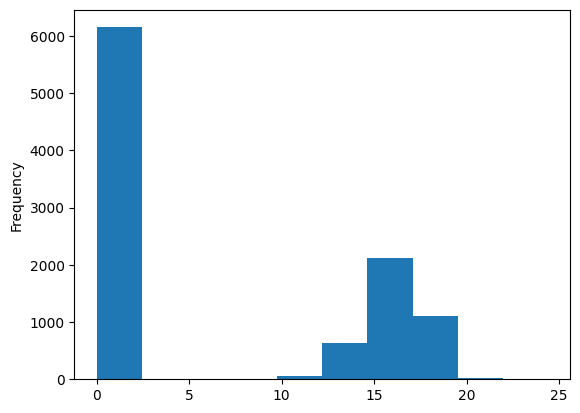

In [2]:
import yfinance as yf
import pandas as pd
data = yf.download("BTC-USD", interval='1m', group_by="Ticker")
data = data["BTC-USD"]
data.index = pd.to_datetime(data.index,unit='ms')
data = data.iloc[:, [0,3,1,2,4]]
def load_and_fill_in_gaps():
    # df.resample('1min').fillna()
    all_times = pd.date_range(
        start=data.index.min(), end=data.index.max(), freq="1min"
    )
    df = data.reindex(all_times)

    # Forward-fill the 'Close' column
    df["Close"] = df["Close"].ffill()

    # Copy the forward-filled 'Close' value to 'Open', 'High', and 'Low'
    df["Open"] = df["Open"].combine_first(df["Close"])
    df["High"] = df["High"].combine_first(df["Close"])
    df["Low"] = df["Low"].combine_first(df["Close"])

    # Set 'Volume' to 0 for the newly created rows
    df["Volume"] = df["Volume"].fillna(0)

    return df


def normalize_volume(df):
    df_norm = df.copy()
    df_norm["Volume"] = np.log(np.add(df_norm["Volume"], 1))

    df_norm["Volume"].plot.hist()

    df_norm["Volume"] = (df_norm["Volume"] - df_norm["Volume"].mean()) / df_norm[
        "Volume"
    ].std()

    return df_norm


def normalize_prices(df_norm):
    columns_combined = pd.concat([
        df_norm["Open"],
        df_norm["High"],
        df_norm["Low"],
        df_norm["Close"],
    ])
    columns_combined_log = np.log(np.add(columns_combined, 1))

    columns = ["Open", "High", "Low", "Close"]
    for column in columns:
        df_norm[column] = np.log(np.add(df_norm[column], 1))

    for column in columns:
        df_norm[column] = (
            df_norm[column] - columns_combined_log.mean()
        ) / columns_combined_log.std()

    return df_norm


def getTestData():
    df = load_and_fill_in_gaps()
    df_norm = normalize_volume(df)
    df_norm = normalize_prices(df_norm)
    return df_norm

test_data = getTestData()

                       open   close    high     low     volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  93.300000
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  93.300000
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  33.676862
2013-04-01 00:10:00   93.30   93.30   93.30   93.30   0.000000
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  20.000000
                        open    close     high      low    volume
2023-10-08 09:24:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:25:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:26:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:27:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:28:00  27912.0  27912.0  27912.0  27912.0  0.000442


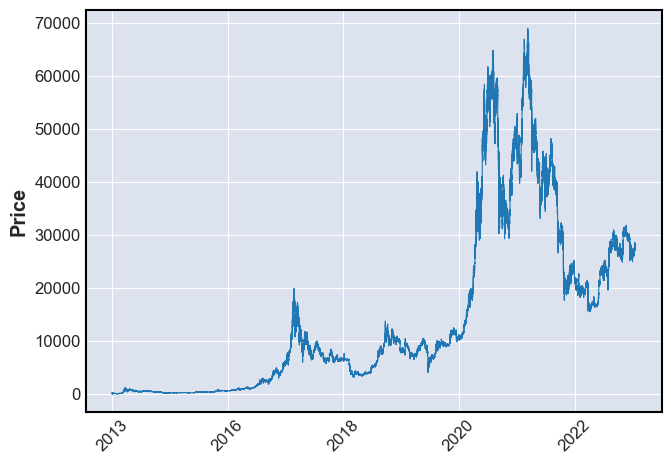

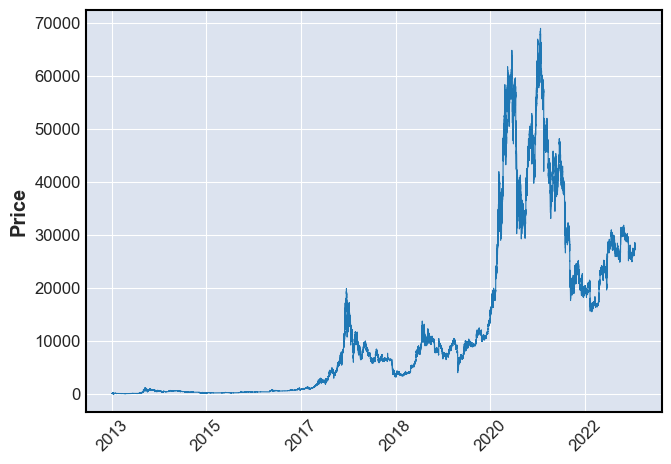

                       open   close    high     low    volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  2.502149
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  2.502149
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  1.758977
2013-04-01 00:10:00   93.30   93.30   93.30   93.30 -0.875289
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  1.386391 open      0.010000
close     1.060000
high      1.060000
low       0.010000
volume   -0.875289
dtype: float64 open      68925.000000
close     68925.000000
high      68958.000000
low       68734.000000
volume        5.725743
dtype: float64
(22132168,)
a 11.14126740407234 0.009950330853168092 8.135346188400915 1.9180121525920217


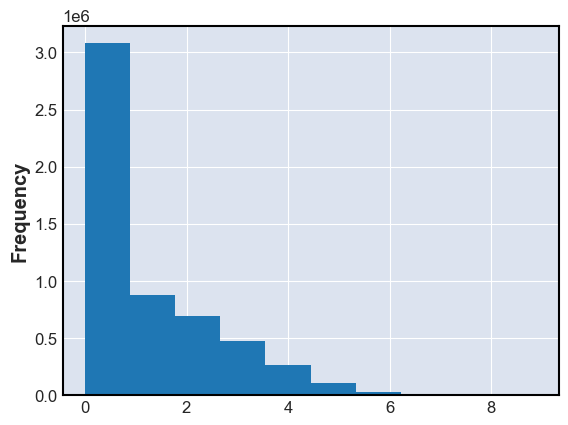

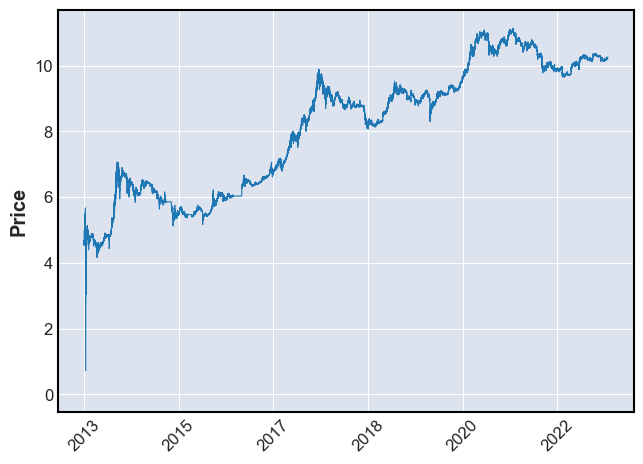

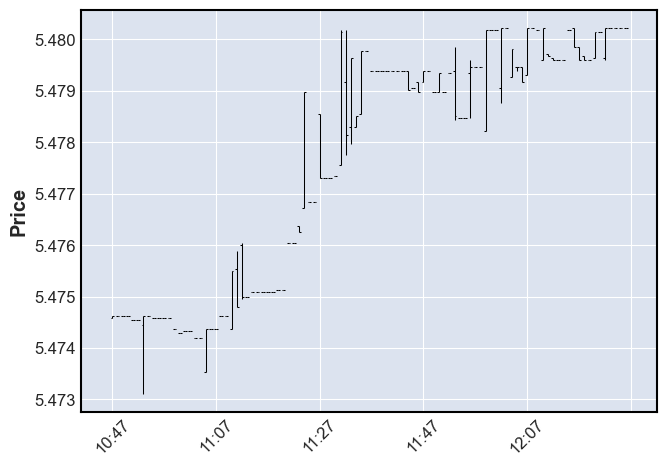

b 11.140788744310507 11.140788744310507 11.14126740407234 11.138013809905521
c 8.135346188400915 1.9180121525920217
d 8.13534605186366 8.135346456755373 8.135742682750113 8.134949562234455
e 1.9180136857301535 1.9180106789128473 1.9180444799344265 1.917980203230276
open 8.13534605186366 1.9180136857301535
high 8.135742682750113 1.9180444799344265
low 8.134949562234455 1.917980203230276
close 8.135346456755373 1.9180106789128473


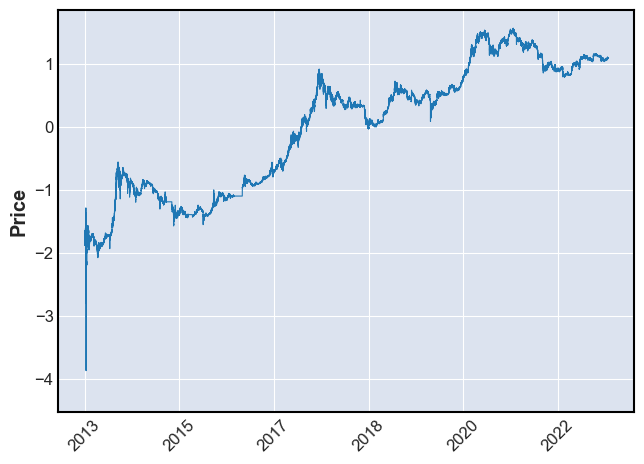

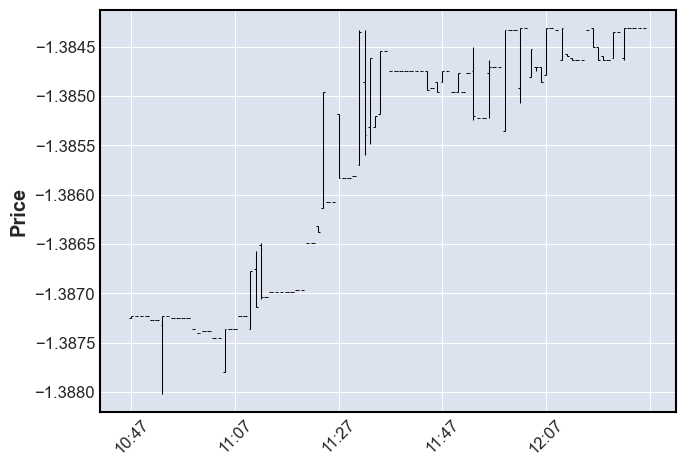

f 1.5669569933892264 1.5669569933892264 1.5672065537276139 1.5655102171520499
g -4.236363073386683 -3.8647514279729176 -3.8647514279729176 -4.236363073386683


In [3]:
%run load_data.ipynb

# Plot the predictions

In [4]:
def getPredictions(data, model, seq_length):
    # Ensure the model is in evaluation mode
    model.eval()

    sequences, targets = create_sequences(data, seq_length)

    # Prepare data for prediction
    entire_loader = DataLoader(TimeSeriesDataset(sequences, targets), batch_size, shuffle=False)

    # Generate predictions
    predictions = []

    with torch.no_grad():
        for x, _ in entire_loader:
            x = x.to(device)
            pred = model(x)
            predictions.append(pred.cpu().numpy())

    predictions = np.concatenate(predictions)
    
    return predictions

In [5]:
import matplotlib.pyplot as plt

def getPredPlot(data, model, seq_length):
    predictions = getPredictions(data.values, model, seq_length)
    # Convert predictions to a DataFrame
    pred_df = pd.DataFrame(predictions, columns=['open', 'close', 'high', 'low', 'volume'])

    # Plot the actual vs predicted close prices using matplotlib
    plt.figure(figsize=(14, 7))
    plt.plot(pred_df['close'], label='Predicted Close', color='red', linestyle='--')
    plt.title('Predicted Close Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import torch
import random
import os
import time

# Create sequences and targets
def create_sequences(data, seq_length, start=0):
    sequences = []
    targets = []
    for j in range(start, len(data) - seq_length, seq_length):
        seq = data[j: j + seq_length]
        target = data[j + seq_length]
        sequences.append(seq)
        targets.append(target)
        
    return np.array(sequences), np.array(targets)


# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


def get_dataloader(data, seq_length=64, batch_size=64, epoch=0):
    # Create sequences and targets
    sequence, target = create_sequences(data, seq_length, epoch%seq_length)

    # Create Datasets
    dataset = TimeSeriesDataset(sequence, target)

    # Create DataLoaders
    loader = DataLoader(dataset, batch_size, shuffle=True)
    return loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create RNN Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, conv1=16, conv2=8):
        super(LSTMModel, self).__init__()

        self.dropout_rate = 0.0
        
        self.input_dim = input_dim
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        self.conv1_channels = conv1
        self.conv2_channels = conv2

        self.sigma = nn.Sigmoid()

        self.dropout1 = nn.Dropout(self.dropout_rate)
        
        self.conv1 = nn.Conv2d(1, self.conv1_channels, (3, 3), padding=1)

        self.selu1 = nn.SELU()

        self.dropout2 = nn.Dropout(self.dropout_rate)
        
        self.conv2 = nn.Conv2d(
            self.conv1_channels, self.conv2_channels, (3, 3), padding=1
        )

        self.selu2 = nn.SELU()

        self.dropout3 = nn.Dropout(self.dropout_rate)
        
        self.conv3 = nn.Conv2d(self.conv2_channels, 1, (3, 3), padding=1)

        self.selu3 = nn.SELU()

        self.dropout4 = nn.Dropout(self.dropout_rate)
        
        # RNN
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=self.dropout_rate)

        self.dropout5 = nn.Dropout(self.dropout_rate)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        if x.size(0) == 1:
            h0 = torch.zeros(self.layer_dim, self.hidden_dim).to(device)
            c0 = torch.zeros(self.layer_dim, self.hidden_dim).to(device)

        self.dropout1.p = self.dropout_rate
        self.dropout2.p = self.dropout_rate
        self.dropout3.p = self.dropout_rate
        self.dropout4.p = self.dropout_rate
        self.dropout5.p = self.dropout_rate
        self.lstm.dropout = self.dropout_rate
        
        inp = self.sigma(x)
        inp = inp.unsqueeze(1)
        conv1 = self.selu1(self.conv1(self.dropout1(inp)))
        conv2 = self.selu2(self.conv2(self.dropout2(conv1)))
        conv3 = self.selu3(self.conv3(self.dropout3(conv2)))

        conv3 = conv3.squeeze()
        out, _ = self.lstm(self.dropout4(conv3), (h0, c0))
        if x.size(0) == 1:
            out = self.fc(out[-1, :])
        else:
            out = self.fc(out[:, -1, :])
        
        return out


def train_model(model, optimizer, criterion, train_loader):
    start = time.time()
    model.train()
    for i, (x, y) in enumerate(train_loader):
        if time.time() - start > 600:
            break

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        wandb.log({"loss": loss})

        loss.backward()
        optimizer.step()
            
    return model


def eval_model(model, criterion, seq_length, test_loader):
    # Evaluate on test data
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_test_pred = model(x_test)
            test_loss += criterion(y_test_pred, y_test).item()

    test_loss /= len(test_loader)  # Average test loss
    return test_loss


criterions = [
    nn.L1Loss(),
    nn.MSELoss(),
    nn.HuberLoss(),
    nn.SmoothL1Loss(),
    nn.SoftMarginLoss(),
]

Test loss 0.2416478991508484


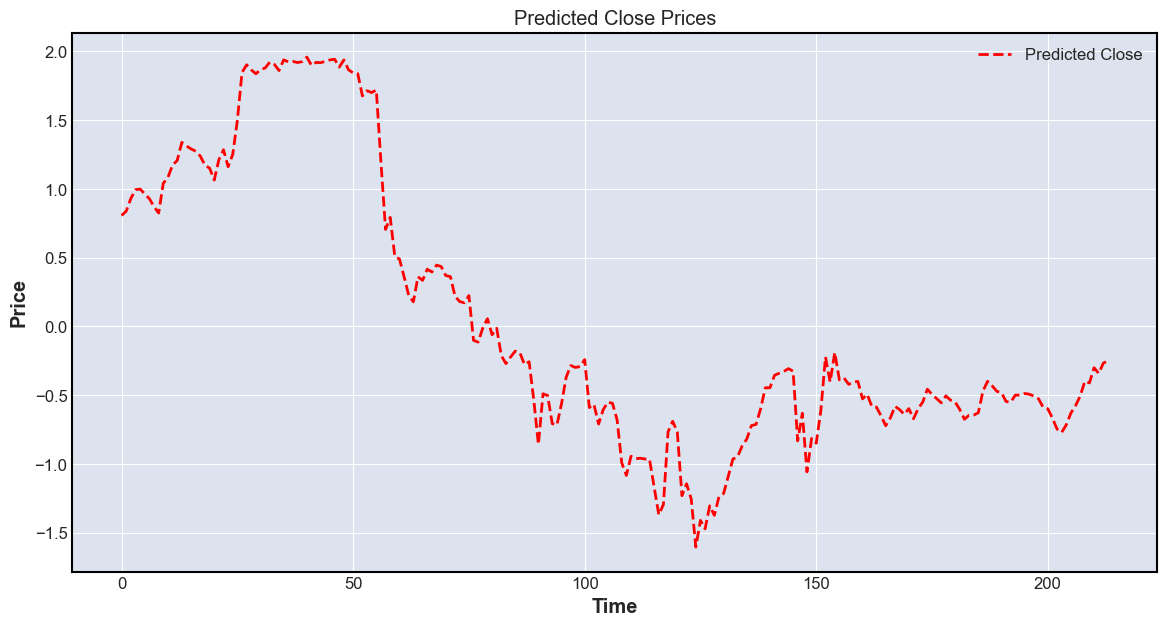

Test loss 0.2479119375348091


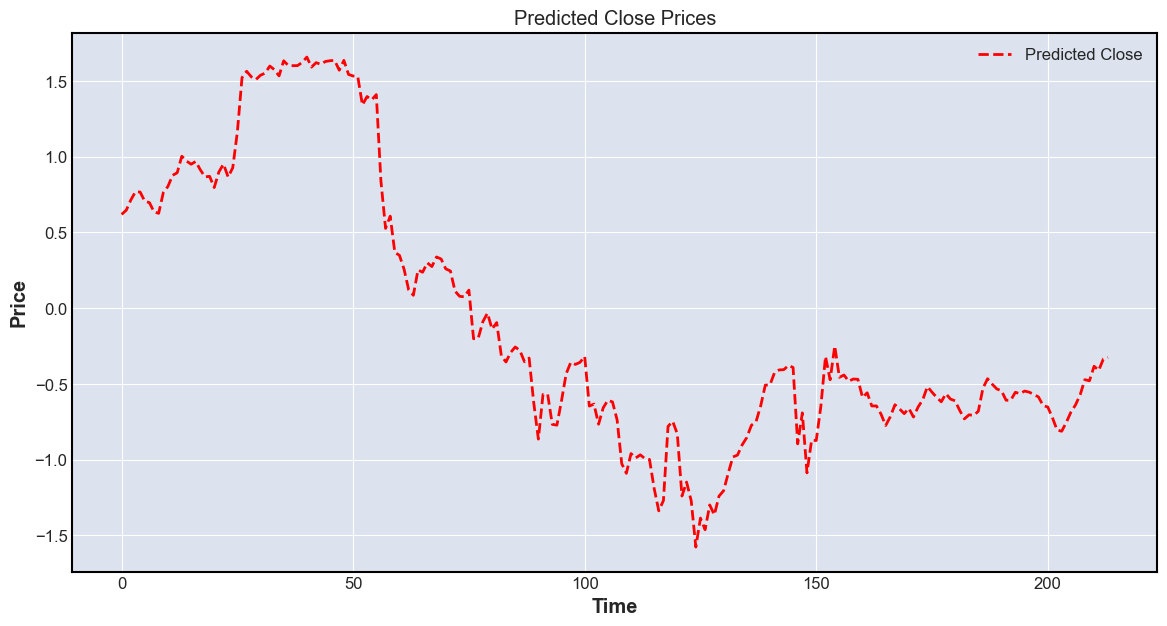

Test loss 0.19553891569375992


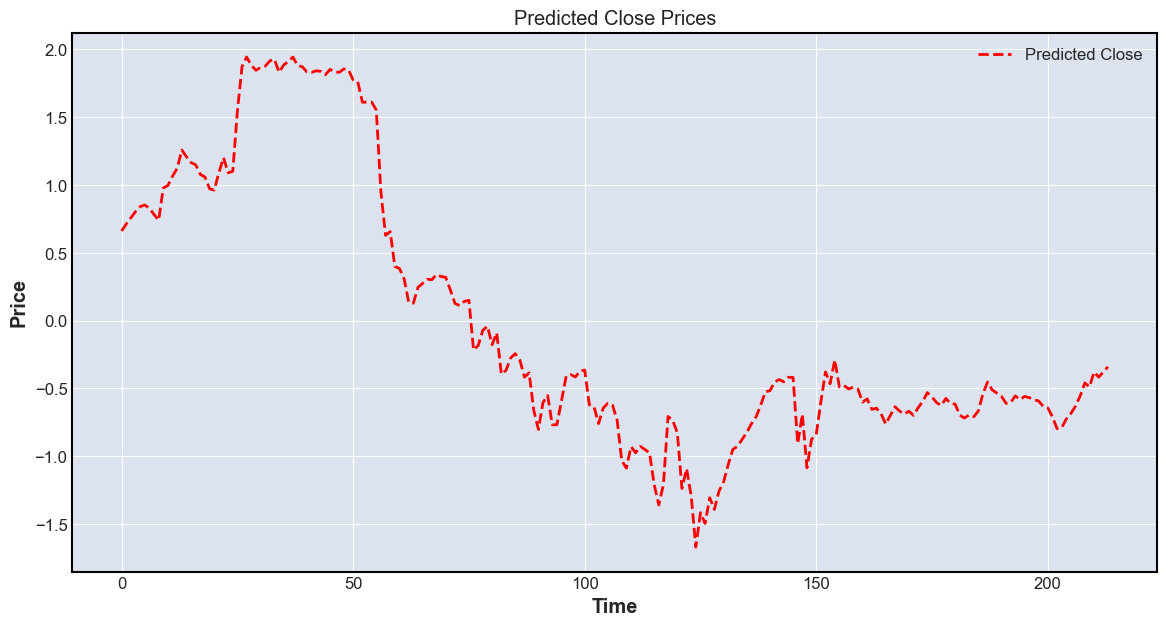

KeyboardInterrupt: 

In [9]:
# hidden_dim = 2
# layer_dim = 163
# conv1 = 51
# conv2 = 3
# criterion_id = 3
# seq_length = 226
# batch_size = 60
# lr = 0.00018619403646471432
# hidden_dim = 27
# layer_dim = 141
# conv1 = 27
# conv2 = 0
# criterion_id = 3
# seq_length = 215
# batch_size = 58
hidden_dim = 1718
layer_dim = 7
conv1 = 9
conv2 = 7
criterion_id = 3
seq_length = 47
batch_size = 56
lr = 1.7202934434750757e-05
model = LSTMModel(
    input_dim=5,
    hidden_dim=hidden_dim,
    layer_dim=layer_dim,
    output_dim=5,
    conv1=conv1,
    conv2=conv2,
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr
)
criterion = criterions[criterion_id]
criterion_test = nn.MSELoss()
epochs = 4*seq_length

import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="io-ug2024-cnn_lstm_params_optimized",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "CNN-LSTM",
    "dataset": "BTCUSD",
    "epochs": epochs,
    }
)

test_loss_over_time = 1 # 1/(2^n) sequence to account for the higher importance of newer values
increase_dropout_counter = 0
input_dropout = 0

import math
def calc_dropout(input_val):
    dropout = (math.atan(input_val/12)*2*0.98)/math.pi
    return dropout

test_loader = get_dataloader(test_data.values, seq_length, batch_size)
for epoch in range(epochs):
    if (increase_dropout_counter == 3): # change to 3
        increase_dropout_counter -= 1
        input_dropout += 1
        model.dropout_rate = calc_dropout(input_dropout)
        print(f"Dropout changed: {model.dropout_rate}")
        
    train_loader = get_dataloader(df_norm.values, seq_length, batch_size, epoch)
    model = train_model(model, optimizer, criterion, train_loader)
    test_loss = eval_model(model, criterion_test, seq_length, test_loader)
    if (test_loss > test_loss_over_time):
        increase_dropout_counter += 1
    else:
        increase_dropout_counter = 0
    test_loss_over_time += test_loss
    test_loss_over_time /= 2
    wandb.log({"val_loss": test_loss})
    print(f"Test loss %s" % (test_loss))
    getPredPlot(test_data, model, seq_length)

In [ ]:
wandb.finish()